# scVelo VelocityBasics × ScGeo (Pancreas demo)

This notebook follows the **scVelo VelocityBasics** flow on `scv.datasets.pancreas()` and injects **ScGeo geometry panels** right after:

- `scv.tl.velocity_graph()`
- `scv.pl.velocity_embedding_stream()`

ScGeo panels answer:

- **Alignment**: is velocity aligned with the cross-condition response direction Δ?
- **Ambiguity**: where do different “direction sources” disagree (unstable / branching / transitional cells)?
- **Quant**: how different are conditions globally (distance + p-value) and locally (overlap)?
- **Composition stats**: which clusters/nodes change composition across conditions?

> Tip: for your real datasets, set `sample_key="donor"` / `"mouse_id"` and use `method="gee"` in `paga_composition_stats` for sample-aware inference.

> **Prereqs (WSL/venv):**
> - `pip install scvelo cellrank bbknn igraph leidenalg scikit-misc`
> - Restart the kernel after installing.

In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import scgeo as sg

scv.settings.verbosity = 2
scv.settings.presenter_view = True

In [2]:
# Load pancreas dataset
adata = scv.datasets.pancreas()

# Quick peek
print(adata)
print("obs keys:", list(adata.obs.columns))
print("layers:", list(adata.layers.keys()))

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'
obs keys: ['clusters_coarse', 'clusters', 'S_score', 'G2M_score']
layers: ['spliced', 'unspliced']


In [3]:
# Choose a condition key for "cross-condition" geometry.
# Pancreas usually has something like "day". If not, we create a proxy.
cond_candidates = ["day", "time", "stage", "experiment", "batch"]
condition_key = next((k for k in cond_candidates if k in adata.obs.columns), None)

if condition_key is None:
    # proxy condition: split clusters into two halves (demo only)
    if "clusters" in adata.obs.columns:
        cl = adata.obs["clusters"].astype(str)
        uniq = sorted(cl.unique())
        half = len(uniq) // 2
        early = set(uniq[:half])
        adata.obs["condition"] = np.where(cl.isin(early), "A", "B")
    else:
        adata.obs["condition"] = np.where(np.arange(adata.n_obs) % 2 == 0, "A", "B")
    condition_key = "condition"

print("Using condition_key =", condition_key)
print("Condition values:", adata.obs[condition_key].astype(str).value_counts().head())

Using condition_key = condition
Condition values: condition
A    2058
B    1638
Name: count, dtype: int64


In [4]:
# Pick group0/group1 as the "earliest" vs "latest" (or A vs B) for Δ shift.
vals = sorted(adata.obs[condition_key].astype(str).unique())
group0, group1 = vals[0], vals[-1]
print("group0 =", group0, "group1 =", group1)

group0 = A group1 = B


## scVelo VelocityBasics pipeline

In [5]:
# Standard VelocityBasics preprocessing
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Compute velocities and graph
scv.tl.velocity(adata, mode="stochastic")
scv.tl.velocity_graph(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_3585/4182325471.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (-1:59:55)
computing moments based on connectivities
    finished (0:00:00)
computing velocities


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01)
computing velocity graph (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=3585) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:07)


In [6]:
# UMAP + velocity embedding
sc.tl.umap(adata)
# compute embedded velocities in UMAP space -> obsm['velocity_umap']
scv.tl.velocity_embedding(adata, basis="umap")

computing velocity embedding
    finished (0:00:00)


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_catego

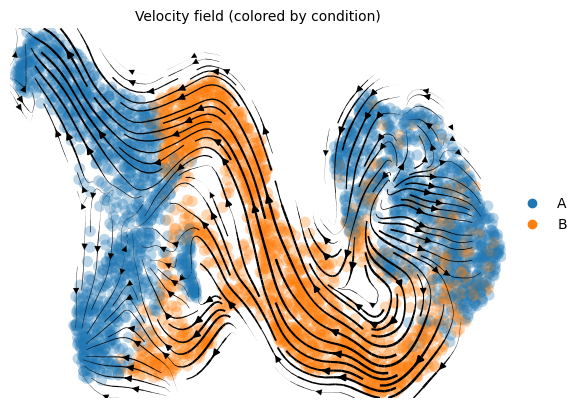

In [7]:
# Velocity stream plot (canonical VelocityBasics visualization)
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color=condition_key,
    legend_loc="right",
    title="Velocity field (colored by condition)",
)

## ScGeo panels (drop-in right after velocity graph/stream)

In [8]:
# 1) Δ shift: cross-condition direction in the same embedding space (UMAP)
sg.tl.shift(
    adata,
    rep="X_umap",
    condition_key=condition_key,
    group0=group0,
    group1=group1,
)

# Optional: also compute per-cluster Δ (helps interpret local programs)
cluster_key = "clusters" if "clusters" in adata.obs.columns else None
if cluster_key is not None:
    sg.tl.shift(
        adata,
        rep="X_umap",
        condition_key=condition_key,
        group0=group0,
        group1=group1,
        by=cluster_key,
    )

print("Shift stored at:", list(adata.uns.get("scgeo", {}).keys()))

Shift stored at: ['shift']


<Axes: title={'center': 'Velocity ↔ Δ alignment'}, xlabel='UMAP1', ylabel='UMAP2'>

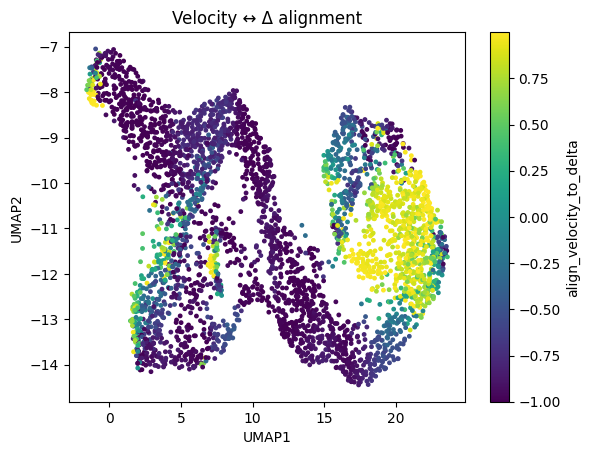

In [9]:
# 2) Alignment: is velocity aligned with Δ?
# velocity embedding is in obsm['velocity_umap']
sg.tl.align_vectors(
    adata,
    vec_key="velocity_umap",
    ref_from_shift=True,
    shift_level="global",
    obs_key="align_velocity_to_delta",
)

sg.pl.score_umap(
    adata,
    "align_velocity_to_delta",
    title="Velocity ↔ Δ alignment",
)

ScGeo: skip delta_by_cluster (shift(by=cluster_key) missing/empty).


<Axes: title={'center': 'Projection disagreement (velocity vs Δ): ambiguity / instability'}, xlabel='UMAP1', ylabel='UMAP2'>

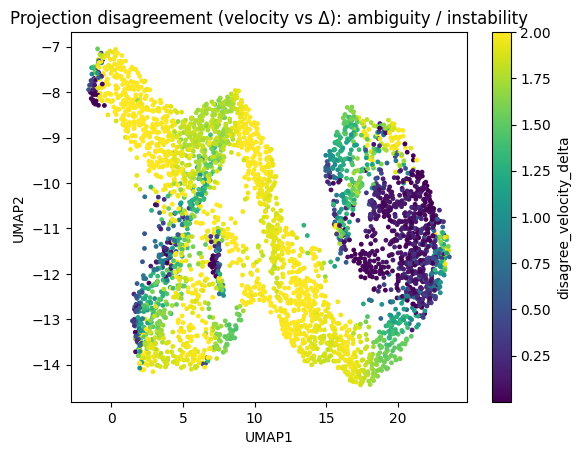

In [10]:
# --- ScGeo: Ambiguity / instability via projection disagreement ---
# Compare velocity direction vs global Δ (and optionally cluster-wise Δ if available).
import numpy as np

sources = [
    {"type": "obsm", "key": "velocity_umap", "name": "velocity"},
    {"type": "shift", "level": "global", "name": "delta_global"},
]

cluster_key = globals().get("cluster_key", None)
shift_by_ok = False
try:
    d_by = adata.uns.get("scgeo", {}).get("shift", {}).get("by", None)
    if isinstance(d_by, dict) and len(d_by) > 0:
        shift_by_ok = any(np.isfinite(v).all() for v in d_by.values())
except Exception:
    shift_by_ok = False

if cluster_key is not None and shift_by_ok:
    sources.append({"type": "shift", "level": "by", "index_key": cluster_key, "name": "delta_by_cluster"})
else:
    print("ScGeo: skip delta_by_cluster (shift(by=cluster_key) missing/empty).")

sg.tl.projection_disagreement(
    adata,
    sources=sources,
    obs_key="disagree_velocity_delta",
)

sg.pl.score_umap(
    adata,
    "disagree_velocity_delta",
    title="Projection disagreement (velocity vs Δ): ambiguity / instability",
)

## Quantify differences: overlap + global distance + p-value

In [11]:
# 4) Density overlap on UMAP: Bhattacharyya / Hellinger
sg.tl.density_overlap(
    adata,
    rep="X_umap",
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=cluster_key if cluster_key is not None else None,
    k=30,
)

print("Density overlap (global):", adata.uns["scgeo"]["density_overlap"]["global"])

Density overlap (global): {'n1': 1638, 'n0': 2058, 'bc': 0.5127725048982739, 'hellinger': 0.6980168300991934}


In [12]:
# 5) Global distribution test on PCA space (energy distance + sample-aware permutation if sample_key exists)
# We'll prefer PCA if available; otherwise fall back to UMAP.
rep = "X_pca" if "X_pca" in adata.obsm else "X_umap"

# Try to find a sample_key. Pancreas often doesn't have donors; for demo we can treat condition as 'sample'.
sample_key = None
for k in ["donor", "sample", "mouse", "batch"]:
    if k in adata.obs.columns:
        sample_key = k
        break
if sample_key is None:
    sample_key = condition_key  # demo fallback (real projects should use true sample IDs)

sg.tl.distribution_test(
    adata,
    rep=rep,
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    sample_key=sample_key,
    method="energy",
    n_perm=200,
    seed=0,
)

print("Distribution test (global):", adata.uns["scgeo"]["distribution_test"]["global"])

Distribution test (global): {'stat': 6.7386932373046875, 'p_perm': 0.5074626865671642, 'n1': 1638, 'n0': 2058, 'n_perm': 200}


## Composition stats: which clusters shift across condition?

In [13]:
# 6) Composition stats on clusters: bootstrap (demo-safe). Use method="gee" + real sample_key in real data.
if cluster_key is None:
    # create a simple leiden clustering if clusters don't exist
    sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
    sc.tl.leiden(adata, resolution=0.8, key_added="leiden")
    cluster_key = "leiden"

sg.tl.paga_composition_stats(
    adata,
    group_key=cluster_key,
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    sample_key=sample_key,
    method="bootstrap",   # switch to "gee" when sample_key is true sample ID
    n_boot=500,
    seed=0,
)

tbl = adata.uns["scgeo"]["paga_composition_stats"]["table"].sort_values("p")
tbl.head(10)

,node,method,effect,CI_low,CI_high,p,n_boot,q
0,Alpha,bootstrap,-0.233722,-0.233722,-0.233722,0.0,500,0.0
1,Beta,bootstrap,-0.287172,-0.287172,-0.287172,0.0,500,0.0
2,Delta,bootstrap,-0.034014,-0.034014,-0.034014,0.0,500,0.0
3,Ductal,bootstrap,-0.445092,-0.445092,-0.445092,0.0,500,0.0
4,Epsilon,bootstrap,0.086691,0.086691,0.086691,0.0,500,0.0
5,Ngn3 high EP,bootstrap,0.391941,0.391941,0.391941,0.0,500,0.0
6,Ngn3 low EP,bootstrap,0.159951,0.159951,0.159951,0.0,500,0.0
7,Pre-endocrine,bootstrap,0.361416,0.361416,0.361416,0.0,500,0.0


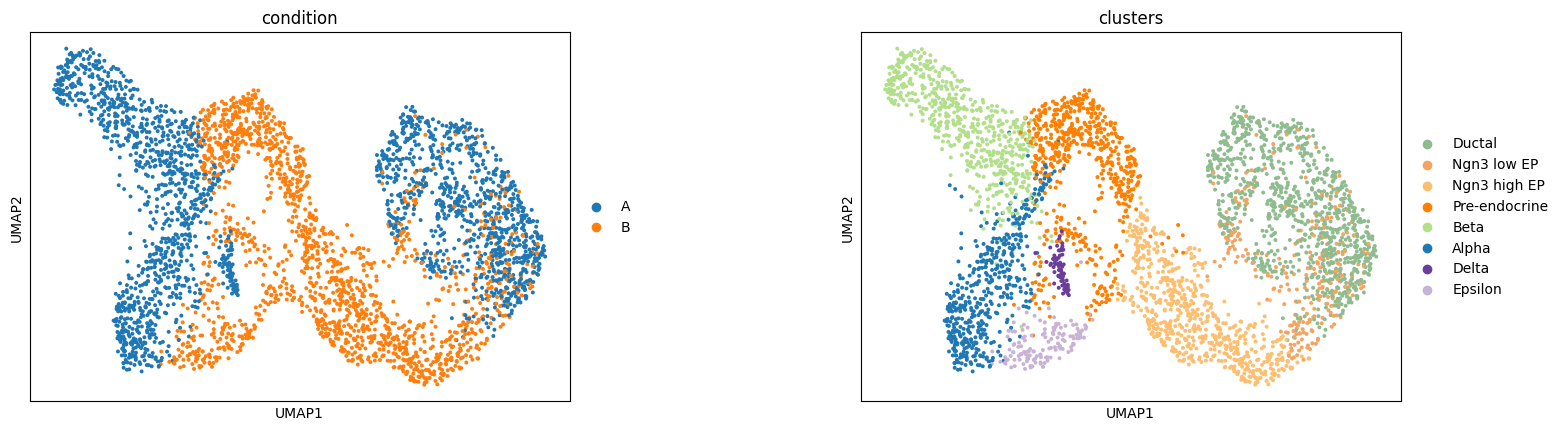

In [14]:
# Visual helper: condition and clusters side-by-side
sc.pl.umap(adata, color=[condition_key, cluster_key], wspace=0.4)

## How this helps cross-condition velocity critique (talking points)

Your ScGeo add-ons give **explicit, testable geometry** around the velocity field:

- **Alignment score (per cell)**: not just “stream looks aligned”, but *how aligned* velocity is to the condition-response Δ.
- **Disagreement / ambiguity (per cell)**: highlights unstable regions where different direction sources conflict.
- **Global distance + permutation p-value**: quantify “overall change” without hand-wavy visual interpretation.
- **Overlap metrics**: quantify “mixing vs separation” (density overlap).
- **Cluster composition stats**: attach OR/CI/p-values to the “pie-chart on PAGA” type narratives.

This directly addresses reviewer-type concerns about over-interpreting qualitative vector fields and comparing across conditions without quantitative controls.